## Unsupervised tests on codebook

In [8]:
from src.preprocessing.preprocess_ucr import UCRDatasetImporter
from src.preprocessing.data_pipeline import build_data_pipeline
from src.utils import load_yaml_param_settings
from src.models.classification import KMeans_VQVAE, evaluate_classifier

import matplotlib.pyplot as plt
import numpy as np

In [2]:
config_dir = 'src/configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['vqvae']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

input_length = train_data_loader.dataset.X.shape[-1]

self.X_train.shape: (500, 128)
self.X_test.shape: (625, 128)
# unique labels (train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
# unique labels (test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [4]:
kmeans_no_split = KMeans_VQVAE(input_length, config,
                            train_data_loader=train_data_loader)
    
kmeans_split_on_train = KMeans_VQVAE(input_length, config,
                                   train_data_loader=train_data_loader,
                                   test_size=0.2)
    
kmeans_split_on_test = KMeans_VQVAE(input_length, config,
                                  train_data_loader=test_data_loader,
                                  test_size=0.2)

In [6]:
num_tests = 50
accs1, mean_acc1 = evaluate_classifier(kmeans_no_split, test_data_loader=test_data_loader, num_tests=num_tests)
accs2, mean_acc2 = evaluate_classifier(kmeans_split_on_train, num_tests=num_tests)
accs3, mean_acc3 = evaluate_classifier(kmeans_split_on_test, num_tests=num_tests)

100%|██████████| 50/50 [00:00<00:00, 57.27it/s]


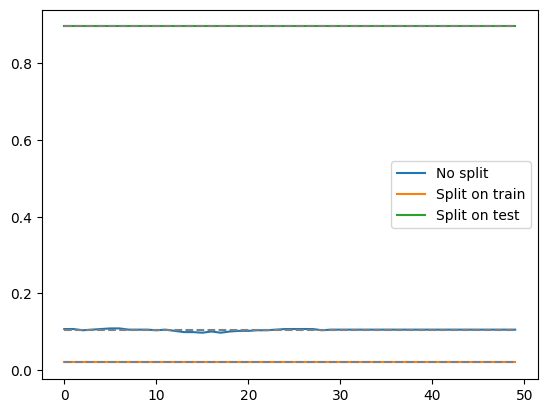

In [10]:
fix, ax = plt.subplots()
x = np.arange(num_tests)
ax.plot(x, accs1, label="No split")
ax.plot(x, [mean_acc1 for _ in range(num_tests)], '--', c='grey')
ax.plot(x, accs2, label="Split on train")
ax.plot(x, [mean_acc2 for _ in range(num_tests)], '--', c='grey')
ax.plot(x, accs3, label="Split on test")
ax.plot(x, [mean_acc3 for _ in range(num_tests)], '--', c='grey')
ax.legend()
plt.show()